In [1]:
using CairoMakie, LinearAlgebra, Dierckx, Optim

In [23]:
function create_model_CRRA(;nk = 101)

    # Create NamedTuple
    p = (;α =  0.33, # Capital share
        β = 0.9, # Discount factor
        γ = 2.0, # Risk aversion
        δ = 0.1, # Dep rate
        A = 10.0, # TFP
        θ = 3.0, # Expanding grid parameter
        maxiter = 10_000, # Maximum number of iterations
        toler = 1e-6, # Tolerance
        print_skip = 100, # Print every n iterations
        kgrid = zeros(Float64, nk), # Initialise Capital grid
        Kss = 1.0, # Initialise steady state capital stock
        nk = nk, # Number of gridpoints
        kmin = 0.75, # Minimum gridpoint (multiple of Kss)
        kmax = 1.25, # Maximum gridpoint (multiple of Kss)
        lb = 0.7, # Lower bound for optimisation (multiple of Kss)
        ub = 1.3) # Upper bound for optimisation (multiple of Kss)

    # Create capital grid
    temp_grid = LinRange(0.0, 1.0, nk)
    kgrid = zeros(nk)
    Kss = ((p.A*p.α*p.β)/(1-p.β*(1.0-p.δ)))^(1/(1.0-p.α))
    kgrid .= p.kmin*Kss .+ (p.kmax*Kss - p.kmin*Kss) .* temp_grid.^p.θ

    # Update NamedTuple
    p = (;p..., kgrid = kgrid, Kss = Kss)

    return p
end

model_CRRA = create_model_CRRA()

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 10.0, θ = 3.0, maxiter = 10000, toler = 1.0e-6, print_skip = 100, kgrid = [45.41037276137309, 45.41040303495493, 45.410614950027814, 45.411190148082795, 45.41231027061091, 45.4141569591032, 45.41691185505073, 45.420756599944525, 45.42587283527564, 45.432442202535114  …  68.22366610281355, 68.98404765791182, 69.76114023018627, 70.55512546112796, 71.36618499222791, 72.19450046497721, 73.04025352086686, 73.90362580138793, 74.78479894803145, 75.68395460228848], Kss = 60.54716368183079, nk = 101, kmin = 0.75, kmax = 1.25, lb = 0.7, ub = 1.3)

In [29]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1
        return log(c)
    else
        return (c^(1-γ))/(1-γ)
    end
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function optimise(grid, interp_v, policy, v_new, pars)
    (; β, nk, lb, ub, Kss) = pars
    for i in 1:nk
        obj(kp) = - (utility(production(grid[i], kp, pars), pars) + β * interp_v(kp))
        res = optimize(obj,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise (generic function with 1 method)

Iterating...
---------------------
Completed iteration 0 with error 0.0694086814279389

---------------------
Completed iteration 100 with error 0.017660837026626568

--------------------
Converged after 193 iterations with error 9.402905060748218e-7

--------------------
  0.182812 seconds (176.74 k allocations: 16.640 MiB, 68.21% compilation time)


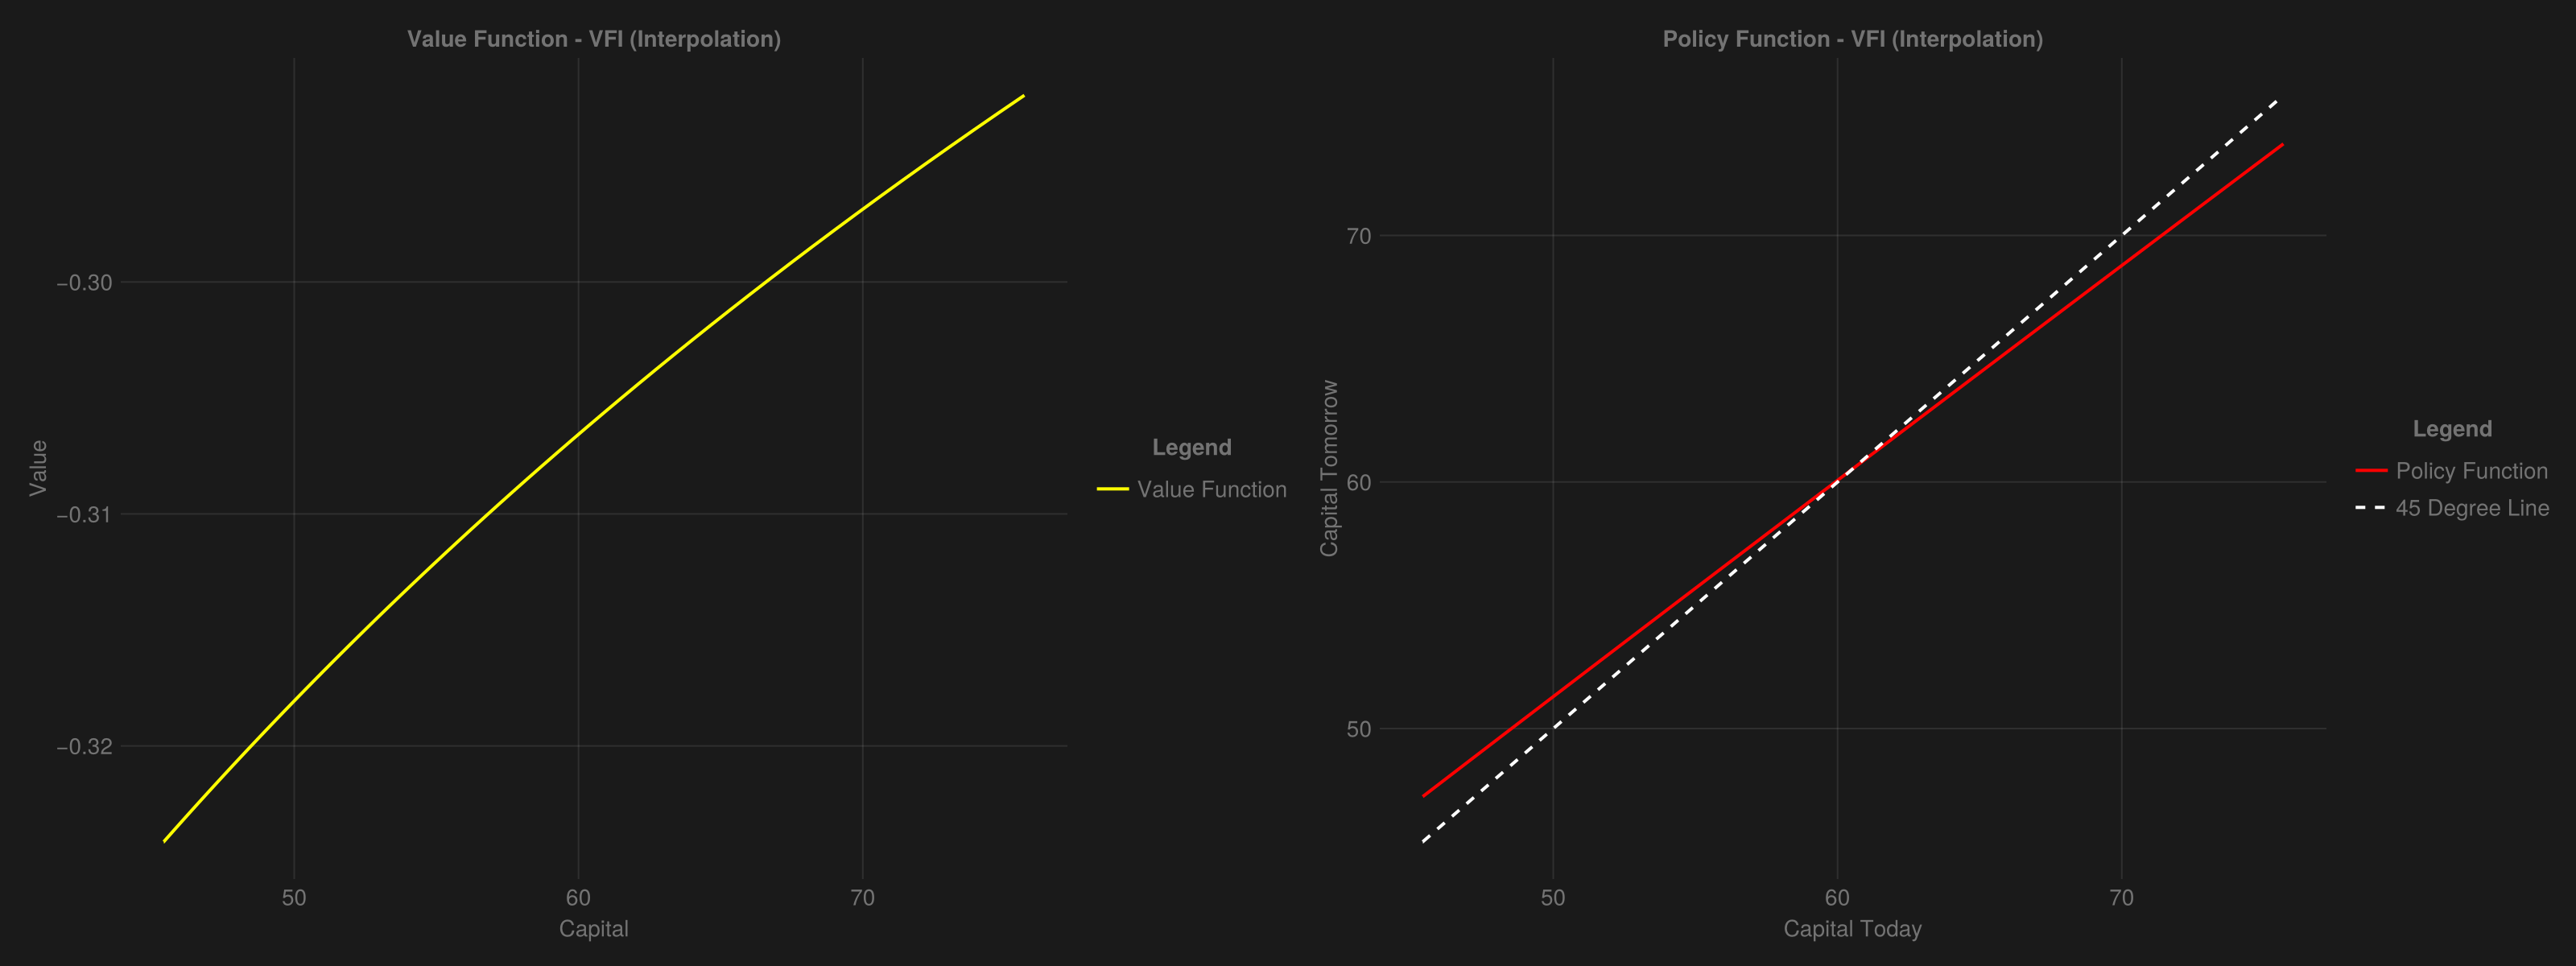

In [30]:
function vfi(pars)
    (; nk, maxiter, toler, print_skip, kgrid) = pars
    v_init = ones(nk)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV(kgrid, v_init)
        v_new, policy = optimise(kgrid, v, policy, v_new, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    return v_init, policy, kgrid 
end

@time begin
    v_out, pol_out, kgrid = vfi(model_CRRA)
end

set_theme!(theme_dark())

K = vec(Float32.(kgrid))
v_init = vec(Float32.(v_out))
policy = vec(Float32.(pol_out))
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, K, v_init, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - VFI (Interpolation)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, K, policy, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, K, K, color = :white, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1

In [48]:
function create_model_CES(;nk = 101)

    # Create NamedTuple
    p = (;α =  0.33, # Capital share
        β = 0.9, # Discount factor
        γ = 2.0, # Risk aversion (needs to be > 1)
        δ = 0.1, # Dep rate
        A = 10.0, # TFP
        θ = 3.0, # Expanding grid parameter
        maxiter = 10_000, # Maximum number of iterations
        toler = 1e-6, # Tolerance
        print_skip = 100, # Print every n iterations
        kgrid = zeros(Float64, nk), # Initialise Capital grid
        Kss = 1.0, # Initialise steady state capital stock
        nk = nk, # Number of gridpoints
        kmin = 0.75, # Minimum gridpoint (multiple of Kss)
        kmax = 1.25, # Maximum gridpoint (multiple of Kss)
        lb = 0.7, # Lower bound for optimisation (multiple of Kss)
        ub = 1.3) # Upper bound for optimisation (multiple of Kss)

    # Create capital grid
    temp_grid = LinRange(0.0, 1.0, nk)
    kgrid = zeros(nk)
    Kss = ((p.A*p.α*p.β)/(1-p.β*(1.0-p.δ)))^(1/(1.0-p.α))
    kgrid .= p.kmin*Kss .+ (p.kmax*Kss - p.kmin*Kss) .* temp_grid.^p.θ

    # Update NamedTuple
    p = (;p..., kgrid = kgrid, Kss = Kss)

    return p
end

model_CES = create_model_CES()

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 10.0, θ = 3.0, maxiter = 10000, toler = 1.0e-6, print_skip = 100, kgrid = [45.41037276137309, 45.41040303495493, 45.410614950027814, 45.411190148082795, 45.41231027061091, 45.4141569591032, 45.41691185505073, 45.420756599944525, 45.42587283527564, 45.432442202535114  …  68.22366610281355, 68.98404765791182, 69.76114023018627, 70.55512546112796, 71.36618499222791, 72.19450046497721, 73.04025352086686, 73.90362580138793, 74.78479894803145, 75.68395460228848], Kss = 60.54716368183079, nk = 101, kmin = 0.75, kmax = 1.25, lb = 0.7, ub = 1.3)

In [41]:
function utility_CES(c, pars)
    (;γ) = pars
    return (c^(1-γ))
end

function interpV_CES(grid, v, pars)
    (;γ) = pars
    interp = Spline1D(grid, v, k=1, bc="extrapolate")
    transformed_interp(x) = interp(x)^(1.0-γ)
    return transformed_interp
end

function optimise_CES(grid, interp_v, policy, v_new, pars)
    (; nk, lb, ub, β, γ, Kss) = pars
    for i in 1:nk
        obj_CES(kp) = - ((1-β)*utility_CES(production(grid[i], kp, pars), pars) + β * interp_v(kp))^(1.0/(1.0-γ))
        res = optimize(obj_CES,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise_CES (generic function with 1 method)

Iterating...
---------------------
Completed iteration 0 with error 0.051810557595252126

---------------------
Completed iteration 100 with error 8.545769768177214e-5

--------------------
Converged after 144 iterations with error 9.216524649553217e-7

--------------------
  0.139476 seconds (117.37 k allocations: 10.401 MiB, 68.26% compilation time)


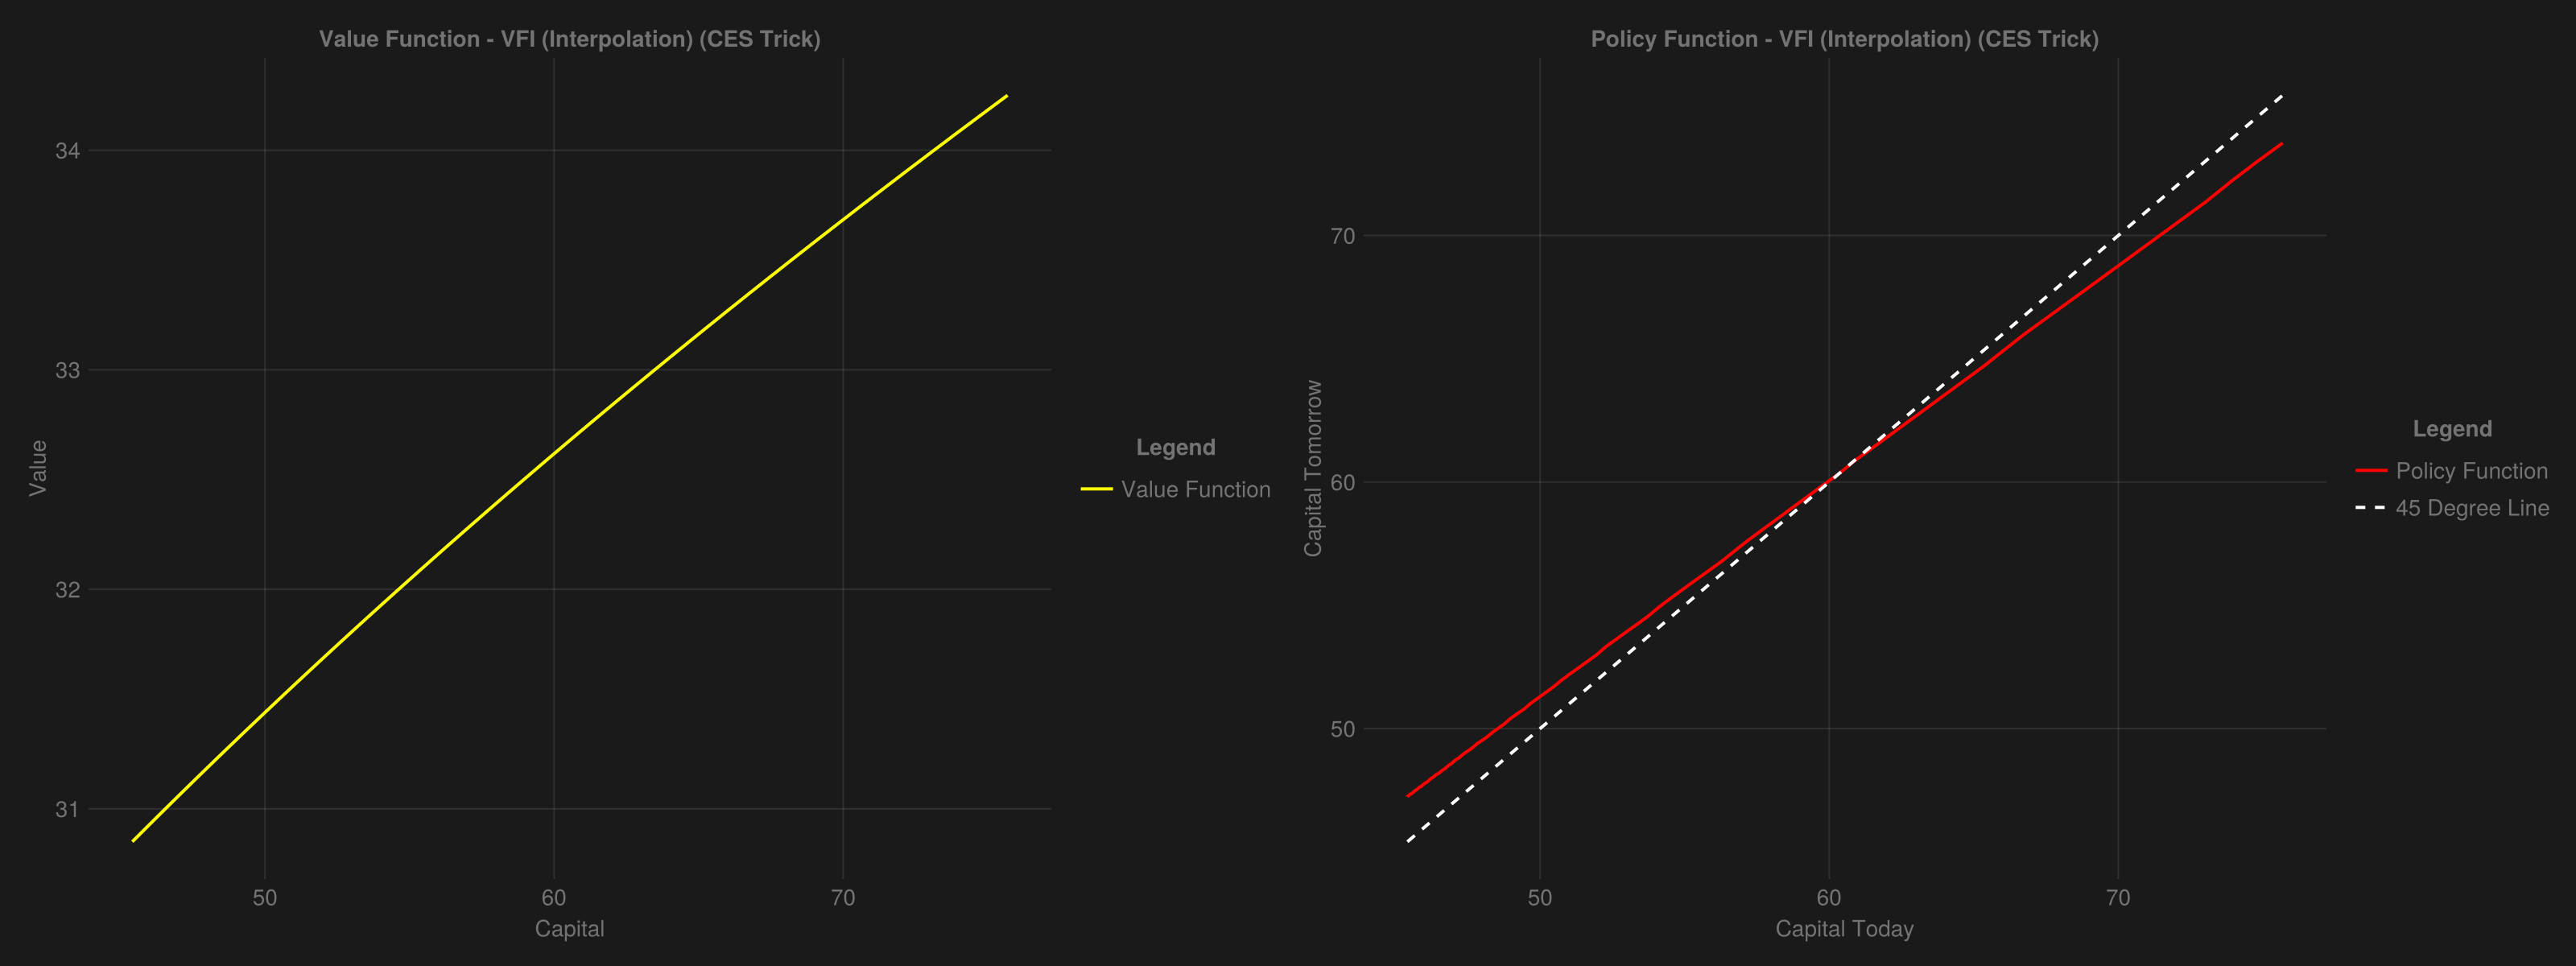

In [49]:
function vfi_CES(pars)
    (; α, β, δ, nk, maxiter, toler, kgrid) = pars
    v_init = ones(nk)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV_CES(kgrid, v_init, pars)
        v_new, policy = optimise_CES(kgrid, v, policy, v_new, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 100 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    return v_init, policy, kgrid
end

@time begin
    v_CES, pol_CES, kgrid = vfi_CES(model_CES)
end


K = vec(Float32.(kgrid))
v_init = vec(Float32.(v_CES))
policy = vec(Float32.(pol_CES))
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation) (CES Trick)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, K, v_init, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - VFI (Interpolation) (CES Trick)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, K, policy, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, K, K, color = :white, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1